                        Project done by Michela Pirozzi MAT:732531 and Sara Ferioli MAT:733105

# LAB 3

## Goal

* Date le feature del dataset,  qualè la combinazione migliore che permette di avere un nuovo contratto (Es. INDETERMINATO) prima del covid? la combinazione di feature è la stessa anche dopo il covid?
* predirre numero di contratti

### Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import LabelEncoder
import math
from sklearn import preprocessing
from scipy.stats import shapiro
from statsmodels.graphics.gofplots import qqplot
from matplotlib import pyplot
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

### Functions

In [2]:
# Method that allow to load ateco csv and prepare the data for the join
def addingAteco():
    df_ateco = pd.read_csv("ateco.csv")
    df_ateco.Descrizione_ateco.replace(r'^.* - ' , '',regex=True, inplace = True,)
    df_ateco = df_ateco.drop("_id",axis=1)
    df_ateco.rename(columns = {"Descrizione_ateco":"SETTOREECONOMICODETTAGLIO"}, inplace = True)
    df_ateco['SETTOREECONOMICODETTAGLIO'] = df_ateco['SETTOREECONOMICODETTAGLIO'].str.upper()
    df_ateco.drop_duplicates(subset="SETTOREECONOMICODETTAGLIO",keep="first",inplace=True)
    return df_ateco

In [3]:
# Method that allow to extract only specific (time) years
# syntax:
# df: dataframe
# time: regex. es: r'20(18|19|20|21)' or r'2020'
def set_years(df,time):
    df.replace(r'..(/|-)..(/|-)','',regex=True, inplace = True)
    df = df[df["DATA"].str.match(time)==True]
    return df

### Import data and analysis

In [4]:
# Load the dataframe
attivati = pd.read_csv("Rapporti_di_lavoro_attivati.csv")

In [5]:
ateco = addingAteco()
ateco

,Codice_ateco,SETTOREECONOMICODETTAGLIO
0,01,COLTIVAZIONI AGRICOLE E PRODUZIONE DI PRODOTTI...
1,01.1,COLTIVAZIONE DI COLTURE AGRICOLE NON PERMANENTI
2,01.11,"COLTIVAZIONE DI CEREALI (ESCLUSO IL RISO), LEG..."
3,01.11.1,COLTIVAZIONE DI CEREALI (ESCLUSO IL RISO)
5,01.11.2,COLTIVAZIONE DI SEMI OLEOSI
...,...,...
3100,96.09.09,ALTRE ATTIVITÀ DI SERVIZI PER LA PERSONA NCA
3101,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
3106,98,PRODUZIONE DI BENI E SERVIZI INDIFFERENZIATI P...
3107,98.1,PRODUZIONE DI BENI INDIFFERENZIATI PER USO PRO...


In [6]:
# Transformations of the strings in upper case, to make join
attivati['SETTOREECONOMICODETTAGLIO'] = attivati['SETTOREECONOMICODETTAGLIO'].str.upper()

In [7]:
# Retrieve only the year from the date 
attivati['DATA'] = pd.to_datetime(attivati['DATA'])
attivati ['ANNO'] = attivati.DATA.dt.year
attivati = attivati.drop(labels='DATA', axis=1)

In [8]:
# Join between the two DataFrames
join = pd.merge(attivati, ateco, on =['SETTOREECONOMICODETTAGLIO'], how='inner')
join

,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco
0,F,60,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97
1,F,33,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97
2,F,45,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97
3,F,61,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97
4,F,20,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97
...,...,...,...,...,...,...,...,...,...,...
9329690,M,38,TRASPORTO MEDIANTE CONDOTTE DI LIQUIDI,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2020,49.50.2
9329691,F,40,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2021,93.19.91
9329692,M,28,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,LICENZA MEDIA,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,MONZA E BRIANZA,ITALIA,2012,93.19.91
9329693,F,25,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2018,93.19.91


In [9]:
# Obtain only the first two digits of the 'codice ateco' to understand the macro category
join.Codice_ateco.replace(r'^(..)\..*' , r'\1',regex=True, inplace = True,)
join

,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco
0,F,60,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97
1,F,33,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97
2,F,45,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97
3,F,61,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97
4,F,20,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97
...,...,...,...,...,...,...,...,...,...,...
9329690,M,38,TRASPORTO MEDIANTE CONDOTTE DI LIQUIDI,LICENZA MEDIA,LAVORO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2020,49
9329691,F,40,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2021,93
9329692,M,28,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,LICENZA MEDIA,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,MONZA E BRIANZA,ITALIA,2012,93
9329693,F,25,RICARICA DI BOMBOLE PER ATTIVITÀ SUBACQUEE,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,COLLABORAZIONE COORDINATA E CONTINUATIVA,NON DEFINITO,BRESCIA,ITALIA,2018,93


In [10]:
# Extract macro category
join2 = pd.merge(join, ateco, on='Codice_ateco', how='inner')
join2

,GENERE,ETA,SETTOREECONOMICODETTAGLIO_x,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y
0,F,60,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
1,F,33,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
2,F,45,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
3,F,61,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
4,F,20,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,INDUSTRIA DEL TABACCO,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO
9329691,M,35,INDUSTRIA DEL TABACCO,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO
9329692,M,27,INDUSTRIA DEL TABACCO,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO
9329693,M,37,INDUSTRIA DEL TABACCO,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO


In [11]:
# Delete the sub category
join2 = join2.drop(labels='SETTOREECONOMICODETTAGLIO_x', axis=1)

In [12]:
# Transformations of the strings in upper case, to make a match, without problem
join2['CONTRATTO']=join2['CONTRATTO'].str.upper()
join2

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y
0,F,60,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
1,F,33,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO DETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
2,F,45,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
3,F,61,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
4,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...
...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO
9329691,M,35,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO
9329692,M,27,NESSUN TITOLO DI STUDIO,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERINALE (O A SCOPO DI SOMMINISTRAZIO...,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO


In [13]:
join2.loc[join2['CONTRATTO'].str.match(r'.*INDETERMINATO.*') == True,"CONTRATTO"]="INDETERMINATO"
join2.loc[join2['CONTRATTO'].str.match(r'.*INDETERMINATO.*') == False,"CONTRATTO"]="NON INDETERMINATO"

# Create mapper
scale_mapper = {'NON INDETERMINATO':0, 'INDETERMINATO':1}

# Map feature values to scale
indeterminato=join2
indeterminato['contratto_transformed'] = indeterminato['CONTRATTO'].replace(scale_mapper)
indeterminato

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0
...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0


### Label Encoder

In [14]:
# Starting the procedure to encode the data
titolostudio = indeterminato.TITOLOSTUDIO.tolist()
modlavoro = indeterminato.MODALITALAVORO.tolist()
prov = indeterminato.PROVINCIAIMPRESA.tolist()
nazionalita = indeterminato.ITALIANO.tolist()
copia = indeterminato.copy()

In [15]:
# Instantiate labelencoder object for each column that we want to encode
le_titolostudio = LabelEncoder()
le_modlavoro = LabelEncoder()
le_prov = LabelEncoder()
le_nazionalita = LabelEncoder()

In [16]:
# Apply the label encoder to the dataset
le_titolostudio.fit(copia['TITOLOSTUDIO'])
le_modlavoro.fit(copia['MODALITALAVORO'])
le_prov.fit(copia['PROVINCIAIMPRESA'])
le_nazionalita.fit(copia['ITALIANO'])

LabelEncoder()

In [17]:
# Transform into integers
transformation_ts = le_titolostudio.transform(indeterminato['TITOLOSTUDIO']) 
transformation_ts

array([8, 8, 8, ..., 8, 0, 0])

In [18]:
# Try to invert a transformation using the object
list(le_titolostudio.inverse_transform([8]))

['NESSUN TITOLO DI STUDIO']

In [19]:
# Transform into integers
transformation_ml = le_modlavoro.transform(indeterminato['MODALITALAVORO']) 
transformation_prov = le_prov.transform(indeterminato['PROVINCIAIMPRESA']) 
transformation_nazion = le_nazionalita.transform(indeterminato['ITALIANO']) 

In [20]:
# Apply label encoder on categorical feature columns
copia['titolostudio_transformed'] = list(transformation_ts)
copia['modalitalavoro_transformed'] = list(transformation_ml)
copia['provincia_transformed'] = list(transformation_prov)
copia['nazionalita_transformed'] = list(transformation_nazion)
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,188
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,89
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89


### Encoding Manually Ordinal Categorical Features

In [21]:
# Function to retrive the original data from the trasformed ones
# syntax:
# value: trasfomed value
# return 'M' if value is 0 otherwise 'F'
def gender(value):
    if value=='0':
        return 'M'
    else:
        return 'F'

In [22]:
# Create mapper
scale_mapper = {'M':0, 'F':1}

# Map feature values to scale
copia['genere_transformed'] = copia['GENERE'].replace(scale_mapper)
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,188,1
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,89,1
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [23]:
# Trasform the column in int type
copia['Codice_ateco']=copia.Codice_ateco.astype(int)

# We remove the outliers. 
copia = copia[copia['ETA']>=15]
copia = copia[copia['ETA']<100]
copia = copia[copia['ANNO']<2022]
copia = copia[copia['ANNO']>2006]
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
0,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,UCRAINA,2020,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,188,1
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
2,F,45,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BERGAMO,ITALIA,2019,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,0,89,1
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [24]:
# anni prima del covid
copia = copia[copia['ANNO']<2019]
copia

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
1,F,33,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
3,F,61,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
5,F,51,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ECUADOR,2017,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,53,1
8,F,31,NESSUN TITOLO DI STUDIO,INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,SENEGAL,2010,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,1,8,2,4,151,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,36,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,35,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,27,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,37,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [25]:
# Drop the columns that have been transformed
transformed_indet = copia.drop(labels =['GENERE', 'TITOLOSTUDIO', 'MODALITALAVORO', 'PROVINCIAIMPRESA', 'ITALIANO', 'SETTOREECONOMICODETTAGLIO_y', 'CONTRATTO'], axis=1)
transformed_indet

,ETA,ANNO,Codice_ateco,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
1,33,2012,97,0,8,2,0,81,1
3,61,2014,97,0,8,4,4,188,1
4,20,2014,97,0,8,2,4,89,1
5,51,2017,97,0,8,2,4,53,1
8,31,2010,97,1,8,2,4,151,1
...,...,...,...,...,...,...,...,...,...
9329690,36,2012,12,0,0,5,0,89,0
9329691,35,2011,12,0,8,4,1,89,0
9329692,27,2009,12,0,8,4,7,89,0
9329693,37,2012,12,0,0,5,0,89,0


In [26]:
# Change the type of all column
transformed_indet['Codice_ateco'] = transformed_indet['Codice_ateco'].astype(str).astype(int)
transformed_indet.dtypes

ETA                           int64
ANNO                          int64
Codice_ateco                  int32
contratto_transformed         int64
titolostudio_transformed      int32
modalitalavoro_transformed    int32
provincia_transformed         int32
nazionalita_transformed       int32
genere_transformed            int64
dtype: object

In [27]:
transformed_indet

,ETA,ANNO,Codice_ateco,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
1,33,2012,97,0,8,2,0,81,1
3,61,2014,97,0,8,4,4,188,1
4,20,2014,97,0,8,2,4,89,1
5,51,2017,97,0,8,2,4,53,1
8,31,2010,97,1,8,2,4,151,1
...,...,...,...,...,...,...,...,...,...
9329690,36,2012,12,0,0,5,0,89,0
9329691,35,2011,12,0,8,4,1,89,0
9329692,27,2009,12,0,8,4,7,89,0
9329693,37,2012,12,0,0,5,0,89,0


In [28]:
bins = [14, 20, 30, 40, 50, 60, 70, 100]
#labels = ['20', '30', '30<x<40', '40<x<50', '50<x<60', '60<x<70','70<']
labels = [15, 20, 30, 40, 50, 60, 70]
transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False})
#X = copia['ETA'].values
copia['ETA']=transformer.fit_transform(copia['ETA'].values)
copia

C:\Users\i\AppData\Local\Temp/ipykernel_8856/2762353899.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia['ETA']=transformer.fit_transform(copia['ETA'].values)


,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
1,F,30,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
3,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,15,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2014,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
5,F,50,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ECUADOR,2017,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,53,1
8,F,30,NESSUN TITOLO DI STUDIO,INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,SENEGAL,2010,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,1,8,2,4,151,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,30,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,30,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2011,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2009,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,30,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2012,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [29]:
bins = [2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020, 2022]
#labels = ['<2006', '2006<x<2008', '2008<x<2010', '2010<x<2012', '2012<x<2014', '2014<x<2016','2016<x<2018','2018<x<2020','2020<']
labels = [2006, 2008, 2010, 2012, 2014, 2016, 2018, 2020]
transformer = preprocessing.FunctionTransformer(pd.cut, kw_args={'bins': bins, 'labels': labels, 'retbins': False})
copia['ANNO']=transformer.fit_transform(copia['ANNO'].values)
copia

C:\Users\i\AppData\Local\Temp/ipykernel_8856/2012182620.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia['ANNO']=transformer.fit_transform(copia['ANNO'].values)


,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO,ANNO,Codice_ateco,SETTOREECONOMICODETTAGLIO_y,contratto_transformed,titolostudio_transformed,modalitalavoro_transformed,provincia_transformed,nazionalita_transformed,genere_transformed
1,F,30,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,HONDURAS,2010,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,0,81,1
3,F,60,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,LECCO,UCRAINA,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,4,4,188,1
4,F,15,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ITALIA,2012,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,89,1
5,F,50,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,ECUADOR,2016,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,0,8,2,4,53,1
8,F,30,NESSUN TITOLO DI STUDIO,INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,LECCO,SENEGAL,2008,97,ATTIVITÀ DI FAMIGLIE E CONVIVENZE COME DATORI ...,1,8,2,4,151,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9329690,M,30,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2010,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0
9329691,M,30,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,BRESCIA,ITALIA,2010,12,INDUSTRIA DEL TABACCO,0,8,4,1,89,0
9329692,M,20,NESSUN TITOLO DI STUDIO,NON INDETERMINATO,TEMPO PIENO,MILANO,ITALIA,2008,12,INDUSTRIA DEL TABACCO,0,8,4,7,89,0
9329693,M,30,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,NON INDETERMINATO,NaN,BERGAMO,ITALIA,2010,12,INDUSTRIA DEL TABACCO,0,0,5,0,89,0


In [30]:
copia["ETA"]=copia["ETA"].astype(int)
copia["ANNO"]=copia["ANNO"].astype(int)

C:\Users\i\AppData\Local\Temp/ipykernel_8856/4237625954.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia["ETA"]=copia["ETA"].astype(int)
C:\Users\i\AppData\Local\Temp/ipykernel_8856/4237625954.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  copia["ANNO"]=copia["ANNO"].astype(int)


In [31]:
# Function to transform the columns ETA, nazionalita_transformed, genere_transformed in a unique column
# with the format: "ETA - nazionalita_transformed - genere_transformed"
# syntax:
# df: Dataframe
# column: column name of the new column
def trasformed_input(df,column):
    df[column] = df["Codice_ateco"].apply(str) + " - " + df["titolostudio_transformed"].apply(str)+ " - " + df["modalitalavoro_transformed"].apply(str)+ " - " + df["provincia_transformed"].apply(str)
    return df.drop(labels=['Codice_ateco','titolostudio_transformed','modalitalavoro_transformed','provincia_transformed'], axis=1)

In [32]:
# Function to retrive the original data from the trasformed ones
# syntax:
# df: Dataframe
# column: column name of the trasformed column
def inverse_trasformed_input(df,column):
    if type(df) is str:
        codice_ateco,titolostudio,modalitalavoro,provincia=df.split(" - ")
        print("Codice_ateco: "+codice_ateco+" titolostudio: "+titolostudio+" modalitalavoro: "+modalitalavoro+" provincia: "+provincia)
        return codice_ateco,titolostudio,modalitalavoro,provincia
    
    df[['Codice_ateco','titolostudio_transformed','modalitalavoro_transformed','provincia_transformed']] = df[column].str.split(" - ",expand=True,)
    return df.drop(labels =[column], axis=1)

In [33]:
# Encoding of the input
transformed_indet=trasformed_input(transformed_indet,'Output')
transformed_indet

,ETA,ANNO,contratto_transformed,nazionalita_transformed,genere_transformed,Output
1,33,2012,0,81,1,97 - 8 - 2 - 0
3,61,2014,0,188,1,97 - 8 - 4 - 4
4,20,2014,0,89,1,97 - 8 - 2 - 4
5,51,2017,0,53,1,97 - 8 - 2 - 4
8,31,2010,1,151,1,97 - 8 - 2 - 4
...,...,...,...,...,...,...
9329690,36,2012,0,89,0,12 - 0 - 5 - 0
9329691,35,2011,0,89,0,12 - 8 - 4 - 1
9329692,27,2009,0,89,0,12 - 8 - 4 - 7
9329693,37,2012,0,89,0,12 - 0 - 5 - 0


In [34]:
# With LabelEncoder we encode the input column
copia = transformed_indet.copy()
le_output = LabelEncoder()
le_output.fit(copia['Output'])
transformation_output = le_output.transform(transformed_indet['Output']) 
copia['Output_transformed'] = list(transformation_output)
copia=copia.drop(labels =['Output'], axis=1)
copia

,ETA,ANNO,contratto_transformed,nazionalita_transformed,genere_transformed,Output_transformed
1,33,2012,0,81,1,31163
3,61,2014,0,188,1,31190
4,20,2014,0,89,1,31169
5,51,2017,0,53,1,31169
8,31,2010,1,151,1,31169
...,...,...,...,...,...,...
9329690,36,2012,0,89,0,1281
9329691,35,2011,0,89,0,1282
9329692,27,2009,0,89,0,1283
9329693,37,2012,0,89,0,1281


### Bilanciamento

In [35]:
copia["contratto_transformed"].value_counts(normalize=True)

0    0.853145
1    0.146855
Name: contratto_transformed, dtype: float64

Non è bilanciato

#### Undersampling randomico

Undersampling perchè diamo più importanza all'INDETERMINATO che ha meno occorrenze

In [36]:
copia[copia["contratto_transformed"]==1].count()

ETA                        1064553
ANNO                       1064553
contratto_transformed      1064553
nazionalita_transformed    1064553
genere_transformed         1064553
Output_transformed         1064553
dtype: int64

In [37]:
copia[copia["contratto_transformed"]==0].count()

ETA                        6184457
ANNO                       6184457
contratto_transformed      6184457
nazionalita_transformed    6184457
genere_transformed         6184457
Output_transformed         6184457
dtype: int64

In [38]:
data_0 = copia[copia["contratto_transformed"]==0].sample(n=1351972,random_state=16)
data_1 = copia[copia["contratto_transformed"]==1]
balanced = data_0.append(data_1)
balanced

C:\Users\i\AppData\Local\Temp/ipykernel_8856/1858138707.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced = data_0.append(data_1)


,ETA,ANNO,contratto_transformed,nazionalita_transformed,genere_transformed,Output_transformed
7747047,44,2017,0,89,0,28070
6913409,28,2017,0,89,0,14941
6465610,32,2012,0,25,0,12562
5093585,54,2015,0,89,1,29808
3869728,51,2014,0,151,0,13143
...,...,...,...,...,...,...
9329650,31,2014,1,70,0,17223
9329653,34,2012,1,89,0,17229
9329675,28,2014,1,89,1,17223
9329683,33,2009,1,89,0,17226


In [39]:
balanced["contratto_transformed"].value_counts(normalize=True)

0    0.559469
1    0.440531
Name: contratto_transformed, dtype: float64

In [40]:
balanced['nazionalita_transformed'].unique()

array([ 89,  25, 151,   1, 144, 105,  54,  61,  38,  22, 139, 188,  43,
        41, 162,  68, 161,  55,  73,  17,  53, 133,  15,  27, 182, 146,
        59, 140,  23, 190, 134, 123,  90, 189,   2,  94,  82,  47, 143,
        46,  57, 112,  67,  44,  10, 103, 194,  81,  65, 126,  84, 152,
       113,  40,  31,  58,  98,  52, 163,   4, 169,  91, 129, 166, 153,
        66,   8,  87,  70,  86,  34,  63, 127,  75, 141, 183,  48, 121,
       155,  51,  50,  21, 109,  28, 178, 110, 191, 192, 179,   0,  76,
       158, 100, 119,  29,  19,  99,  85, 128, 138, 114, 116,  11, 157,
       197, 160,  45,  88, 131,  32,  42, 164,  92,  36, 108, 195, 154,
        62, 176, 101, 149, 168, 115, 120,  33, 175,  30,  14, 130, 145,
        72, 181,  77, 117, 159, 106,  35,   5,  83, 174, 111,  80, 132,
        20, 136,   9,  12, 102,  69,  64, 156,  56,  39,  79, 107,  97,
       104, 177,  49,  60, 198,  96, 186,  37,  24,   6, 184,   7,   3,
       124, 171, 118,  95,  16, 196, 122,  13,  71, 147, 142,  7

#### Crea train e test

In [40]:
X = balanced[["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"]].values
y = pd.DataFrame(balanced['Output_transformed'].copy()).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 7)

### Decision Tree

In [41]:
def dct(X_train, y_train):
    dct = tree.DecisionTreeClassifier()
    #dct.fit(X_train, y_train)
    
    DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=9, 
                           min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=None, 
                           random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, 
                           class_weight=None)
    
    return dct

In [43]:
dct = dct(X_train, y_train)
dct.fit(X_train, y_train)

DecisionTreeClassifier()

In [44]:
# With the following sintax we will create a .dot file with the code for visualizing th tree
tree.export_graphviz(dct, out_file='tree.dot', feature_names=["ETA","ANNO","contratto_transformed","nazionalita_transformed","genere_transformed"])

[Text(0.45058214052932616, 0.9821428571428571, 'X[3] <= 61.5\ngini = 0.998\nsamples = 1691567\nvalue = [1, 5, 1 ... 1, 78, 6]'),
 Text(0.29571084447766005, 0.9464285714285714, 'X[3] <= 54.5\ngini = 0.989\nsamples = 225587\nvalue = [0, 0, 0 ... 0, 14, 3]'),
 Text(0.22976117375656338, 0.9107142857142857, 'X[3] <= 53.5\ngini = 0.991\nsamples = 202154\nvalue = [0, 0, 0 ... 0, 9, 3]'),
 Text(0.12973809559883584, 0.875, 'X[3] <= 1.5\ngini = 0.992\nsamples = 155235\nvalue = [0, 0, 0 ... 0, 9, 3]'),
 Text(0.009730364071820949, 0.8392857142857143, 'X[4] <= 0.5\ngini = 0.984\nsamples = 38355\nvalue = [0, 0, 0 ... 0, 3, 0]'),
 Text(0.0048754788800967844, 0.8035714285714286, 'X[2] <= 0.5\ngini = 0.972\nsamples = 27060\nvalue = [0, 0, 0 ... 0, 3, 0]'),
 Text(0.002413457329877692, 0.7678571428571429, 'X[3] <= 0.5\ngini = 0.991\nsamples = 9815\nvalue = [0, 0, 0 ... 0, 2, 0]'),
 Text(0.0011704591839243824, 0.7321428571428571, 'X[0] <= 25.0\ngini = 0.913\nsamples = 356\nvalue = [0, 0, 0 ... 0, 0, 0]'),

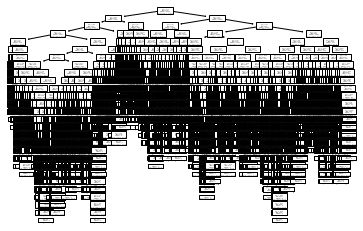

In [45]:
tree.plot_tree(dct)

#### Post pruning techniques

dà errore

In [49]:
X_train=X_train.astype(np.uint8)
y_train=y_train.astype(np.uint8)
path = dct.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
clfs = []
for ccp_alpha in ccp_alphas:
    clf = tree.DecisionTreeClassifier(ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

MemoryError: could not allocate 67108864 bytes

In [ ]:
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

#### Confusion Matrix

Non eseguire

In [ ]:
import matplotlib.pyplot as plt

columns = balanced['Output_transformed'].distinct()
confusion = metrics.confusion_matrix(y_true, y_pred)

plt.imshow(confusion, cmap=plt.cm.Blues, interpolation='nearest')
plt.xticks([0,1,2], columns, rotation='vertical')
plt.yticks([0,1,2], columns)
plt.colorbar()

plt.show()

### ARIMA

In [ ]:
bal1 = balanced.copy()
bal1.loc[:,"ANNO"] = pd.to_datetime(bal1.loc[:,"ANNO"].astype(str))
bal1.loc[:,"Anno"] = bal1["ANNO"].dt.year
bal1 = bal1.drop(columns = ['ANNO'])
bal1 = bal1 [['Anno', 'contratto_transformed', 'ETA', 
            'nazionalita_transformed', 'genere_transformed', 'Output_transformed']]
bal1

In [ ]:
bal2 = bal1.groupby("Anno").size().reset_index(name='count')
bal2 = bal2.set_index('Anno')
f, ax1 = plt.subplots(1,1,figsize=(15,5))
bal2.plot(ax=ax1)
ax1.set_xlabel("Year")
ax1.set_ylabel("Count")
plt.grid(True)

In [ ]:
from statsmodels.tsa.stattools import adfuller

results = adfuller(bal2["count"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
plt.rcParams['figure.figsize'] = 20, 10
# Additive decomposition
decomposed_add = seasonal_decompose(bal2, model="additive", period=5)
add = decomposed_add.plot()
plt.show()

In [ ]:
bal_diff = bal2.diff().dropna()
plt.figure(figsize=(12,5))
ax1 = bal_diff["count"].plot()
ax1.set_xlabel("Anno")
ax1.set_ylabel("diff")
plt.grid(True)
plt.show()

In [ ]:
results = adfuller(bal_diff["count"])
print('ADF Statistic: %f' % results[0])
print('p-value: %f' % results[1])

In [ ]:
results = adfuller(bal2.diff().diff().dropna()["count"])
print('ADF Statistic: %f' % results[0])
print("P-value of a test is: {}".format(results[1]))

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig,ax = plt.subplots(2,1,figsize=(20,10))
plot_acf(bal_diff, lags=4, ax=ax[0])
plot_pacf(bal_diff, lags=4, ax=ax[1])
plt.show()

In [ ]:
from pandas.plotting import lag_plot

fig, ax = plt.subplots(figsize=(5, 5))
ax = lag_plot(bal_diff, lag=1)
ax = lag_plot(bal_diff, lag=2, c="orange")

plt.show()

CONTROLLARE I VALORI DI P E Q CHE DEVONO ESSERE IN CORRISPONDENZA
DEL VALORE DI ADFULLER FATTO SOPRA!!!

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

arima_df = pd.DataFrame(columns=["p","q","aic","bic"])

i=0
# Loop over p values from 0-3
for p in range(3):
    # Loop over q values from 0-3
    for q in range(3):
        
        try:
            # creating and fitting ARIMA(p,1,q) model
            model = ARIMA(bal2["count"].astype(float), order=(p,1,q))
            results = model.fit()
            
            # Printing order, AIC and BIC
            #print(p, q, results.aic, results.bic)
            arima_df.loc[i,"p"] = p
            arima_df.loc[i,"q"] = q
            arima_df.loc[i,"aic"] = results.aic
            arima_df.loc[i,"bic"] = results.bic
            i = i+1
        except:
            #print(p, q, None, None)
            i = i+1
    
arima_df["sum_aic_bic"] = arima_df["aic"]+arima_df["bic"]
arima_df.sort_values(by="aic", ascending=False, inplace=True)
arima_df

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model2 = SARIMAX(bal2, order=(1,1,0), seasonal_order=(0,1,0,12))
results = model2.fit()
results.summary()

In [ ]:
plt.rcParams['figure.figsize'] = 12, 8
plot = results.plot_diagnostics()

In [ ]:
# Create SARIMA mean forecast
forecast = results.get_forecast(steps=40)
lower = forecast.conf_int()["lower count"]
upper = forecast.conf_int()["upper count"]

# Plot mean SARIMA predictions
fig,ax = plt.subplots(1,1,figsize=(20,10))

plt.plot(bal2, label='original')
plt.plot(forecast.predicted_mean, label='SARIMAX', c="r")
plt.fill_between(forecast.conf_int().index, 
                 lower,upper,
                 color='pink')
plt.xlabel('Year')
plt.ylabel('No of contracts')
plt.legend()
plt.show()

In [ ]:
df_train = []
for i in range(len(X_train)):
    sub=np.append(X_train[i],y_train[i])
    df_train= np.append(df_train,sub)
df_train